<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb-log/Logging_Strategies_for_High_Frequency_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="http://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />

<div><img /></div>

<img src="https://wandb.me/mini-diagram" width="650" alt="Weights & Biases" />

<div><img /></div>

# 🪵 Logging Strategies for High-Frequency Data

Sometimes, you need to log metrics that are generated
**at high frequency**.
This might happen if you log:
- loss and metrics on _every batch_ during training,
- reward on _each step_ of each episode during simulation, or
- outputs, media, and metrics on _every input_ during analysis.

This can lead to substantial slowdown
if the logging calls,
which may need to write to disk or communicate over a network,
end up much slower than the iterations --
training will finish, but `wandb` will still be catching up.

This limitation is fundamental:
our experiments generate large quantities of information,
and if we need [lossless](https://en.wikipedia.org/wiki/Lossless_compression)
access to all of that information,
we will need to [pay a cost](https://en.wikipedia.org/wiki/Landauer%27s_principle).

But if we are clever, we can create a summary
that's much smaller but doesn't lose too much information, just as
[a JPEG or mp3 file](https://en.wikipedia.org/wiki/Lossy_compression)
summarizes a TIFF image or a WAV file into a smaller amount of disk space
while preserving its contents as much as possible.

In this notebook we'll cover how to use three
common summarization strategies with `wandb.log`,
along with their benefits and drawbacks:
1. **downsampling**, which takes a (hopefully) representative subset,
1. **summarization**, which uses descriptive statistics, like mean or median, and
1. **batching**, which uses histograms.

# Setup
To get started, we install wandb and log in.

If this is your first time using wandb, you'll need to sign up as well.

In [ ]:
%%capture
# install the package
!pip install wandb -qq

In [ ]:
import wandb

In [ ]:
wandb.login()

In [ ]:

import random

timing_header = "=" * 5 + " Timing Results " + "=" * 5

# 🧲 Downsampling

The simplest solution is to just log less frequently.
It is also very common:
many logging libraries include an option like
[`log_every_n_steps`](https://pytorch-lightning.readthedocs.io/en/latest/extensions/logging.html#logging-frequency),
which triggers logging less frequently.

This is a basic form of [down-sampling a signal](https://en.wikipedia.org/wiki/Downsampling_(signal_processing)).
It has the advantage of being simple to implement.

It has two disadvantages. First,
[aliasing of high-frequency components](https://en.wikipedia.org/wiki/Aliasing)
like noise might make the logged quantities appear to oscillate.
This is typically not a serious issue for ML experiment metrics.
Second, all information about other iterations is completely lost.

> There's one special consideration
for all of these summary methods when logging with W&B:
if you have metrics being logged at different frequencies,
[the "step" value](https://docs.wandb.ai/guides/track/log#incremental-logging)
used as the x-axis for default charts
becomes less interpretable.
Even if you don't, it's a good idea to include timing information,
like batch index, epoch, or optimization step index,
when logging.
Below, we track the `iter`ation count of the main for loop.

In [ ]:
%%time

total_steps = 100_000
log_every = 500

run = wandb.init(project="perf-log",
                 name="downsample")
with run:
    random.seed(117)
    metric = 0
    for iter in range(total_steps):
        metric += random.randint(-1, 1)

        if (iter + 1) % log_every == 0:  # subsampling
            run.log({"metric": metric, "iter": iter})

    print("Run Finished!")

print("Logging Finished!")
print("\n" + timing_header)

The run and logging finish in a few seconds on commodity hardware.

At the bottom of the notebook,
there's a cell that logs the value of `metric`
on every iteration.
That cell takes roughly 25x longer to run.

The screenshot below compares the results logged by these two cells
in the W&B interface.
Note how small the differences are,
even though we threw out every 500th entry
-- this is typical for ML experiment metrics.
You can get away with throwing out a lot!

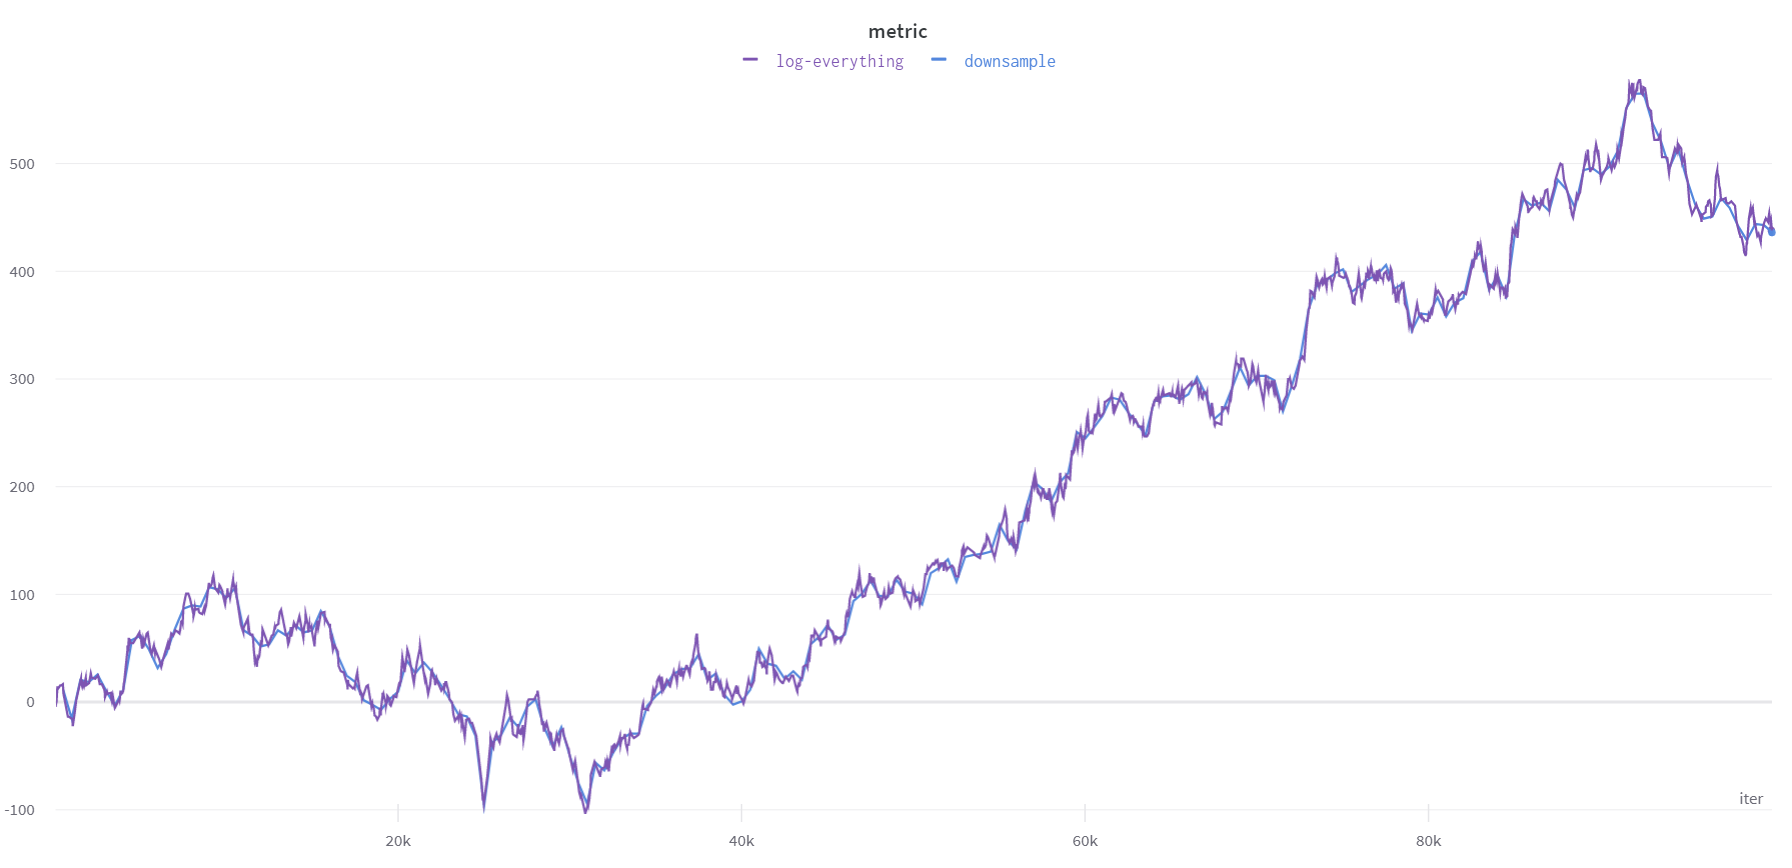

# 📝 Summarization

Downsampling approaches our problem from a signal processing perspective.
From the perspective of statistics, on the other hand,
by calculating a single number to represent our metric data
we have chosen a
[summary statistic](https://en.wikipedia.org/wiki/Summary_statistics).

This point of view suggests an alternative approach:
use common statistical estimators, like the mean, median, or mode.
If our goal is to capture the "average" or "typical" behavior
of the metric over a period,
these summaries get
[closer to the truth](https://en.wikipedia.org/wiki/Minimum-variance_unbiased_estimator)
than does a randomly or intermittently chosen data point.

Below, we'll take the mean after each `log_every` steps.
As before, we make sure to log the `iter`ation count
along with the mean when we call `wandb.log`.

In [ ]:
%%time

total_steps = 100_000
log_every = 500

run = wandb.init(project="perf-log",
                 name="summarizing")

with run:
    random.seed(117)
    metric, running_average = 0, 0
    for iter in range(total_steps):
        metric += random.randint(-1, 1)
        running_average += metric / log_every

        if (iter + 1) % log_every == 0:
            run.log({"metric": running_average, "iter": iter})
            running_average = 0

    print("Run Finished!")

print("Logging Finished!")
print("\n" + timing_header)

Once again, we can compare the result to the true signal.
The differences are again small:

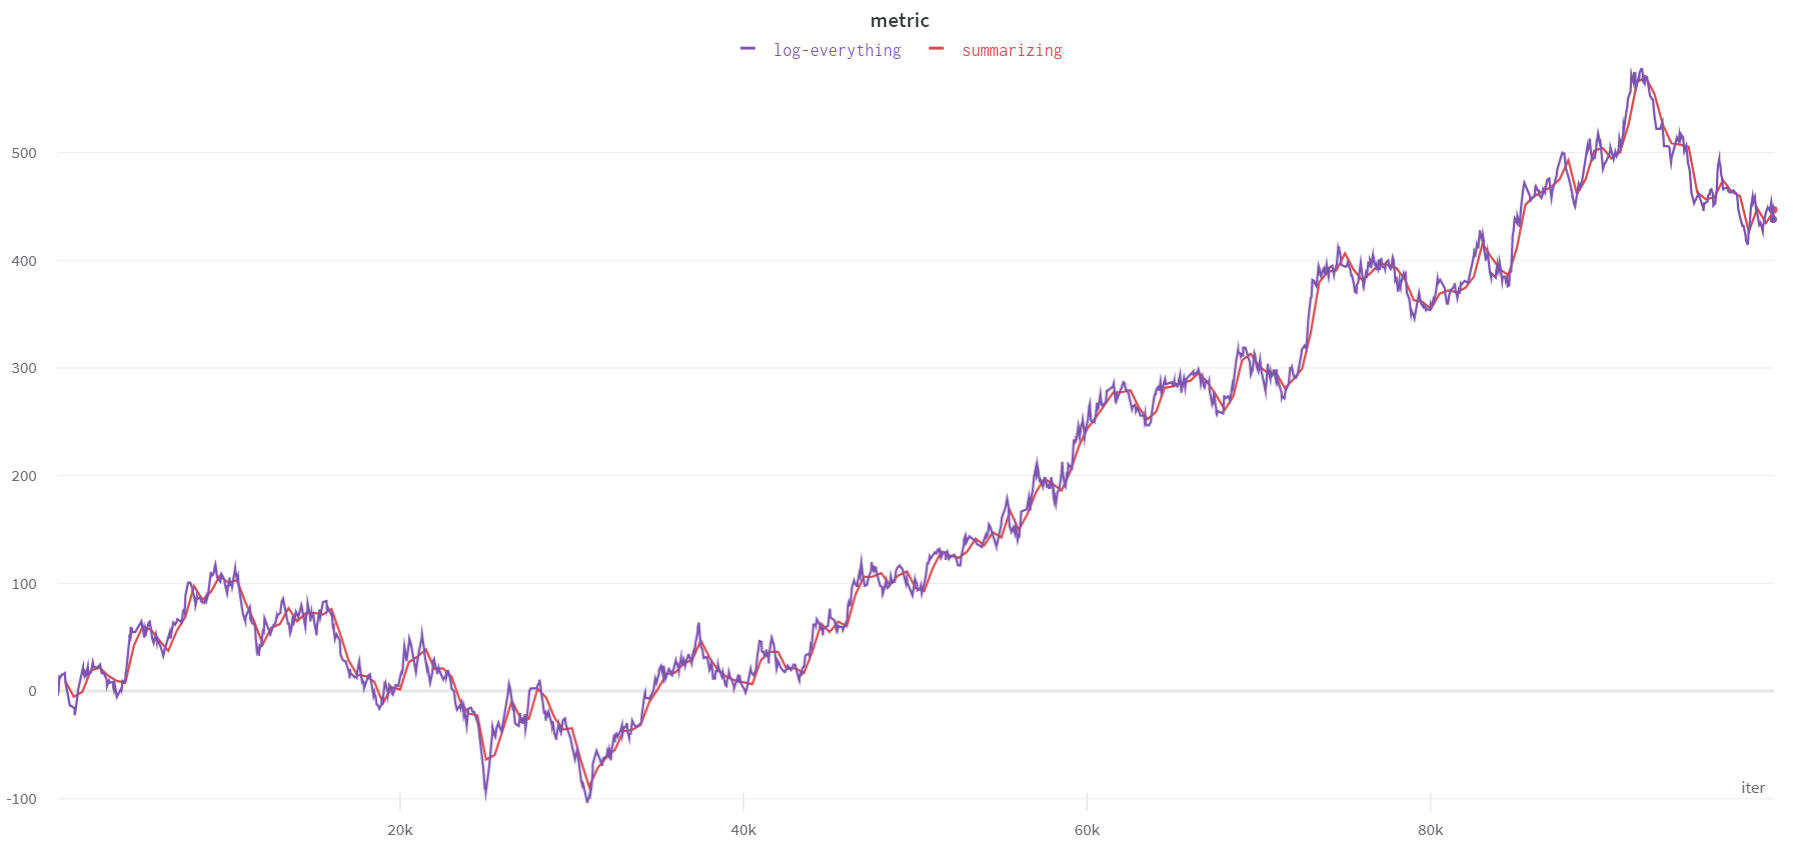

In signal processing,
what we did would be called a
[low-pass filter](https://en.wikipedia.org/wiki/Low-pass_filter).
In the terminology of deep neural networks,
it's a type of
[strided, one-dimensional average pooling](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool1d.html#torch.nn.AvgPool1d).

Both of these give good intuition for the disadvantages of this method:
rapid changes are missed and the reported signal lags slightly.

# 👯 Batching with `wandb.Histogram`

But wait -- why stop at a single number?
Summary statistics and estimators come from early 20th century statistics,
which allowed strong modeling assumptions to make up for
small data and limited compute.

Contemporary ML, and some contemporary statistics,
operates in the opposite context.
We aim to presume as little as possible about our data
and tolerate laborious calculations,
which we outsource to computers.

So instead of selecting a single summary statistic,
as in classical parametric statistics,
why not use a technique from
[non-parametric statistics](https://en.wikipedia.org/wiki/Nonparametric_statistics)?

This may sound like an over-complication, but
[the humble histogram is actually a simple, non-parametric method](https://en.wikipedia.org/wiki/Nonparametric_statistics#Non-parametric_models)
for estimating distributions.
The histogram captures not only the average or typical behavior
of the metric at a given moment,
but also the variability and spread.

With `wandb`, using it is as easy as
swapping out the calculation of the mean
for a call to `wandb.Histogram`.
The resulting chart will also include a
[kernel density estimate](https://en.wikipedia.org/wiki/Kernel_density_estimation)
(or "KDE"), which is a fancier, continuous version of a histogram --
and also a method from non-parametric statistics.

In [ ]:
%%time

total_steps = 100_000
log_every = 500

run = wandb.init(project="perf-log",
                 name="batch")
with run:
    random.seed(117)
    metric, batch = 0, []
    for iter in range(total_steps):
        metric += random.randint(-1, 1)
        batch.append(metric)

        if (iter + 1) % log_every == 0:
            run.log({"metric_hist": wandb.Histogram(batch), "iter": iter})
            batch = []

    print("Run Finished!")

print("Logging Finished!")
print("\n" + timing_header)

Though it takes a bit more effort to read,
the histogram chart captures far more than the
scalar-valued summary charts did.

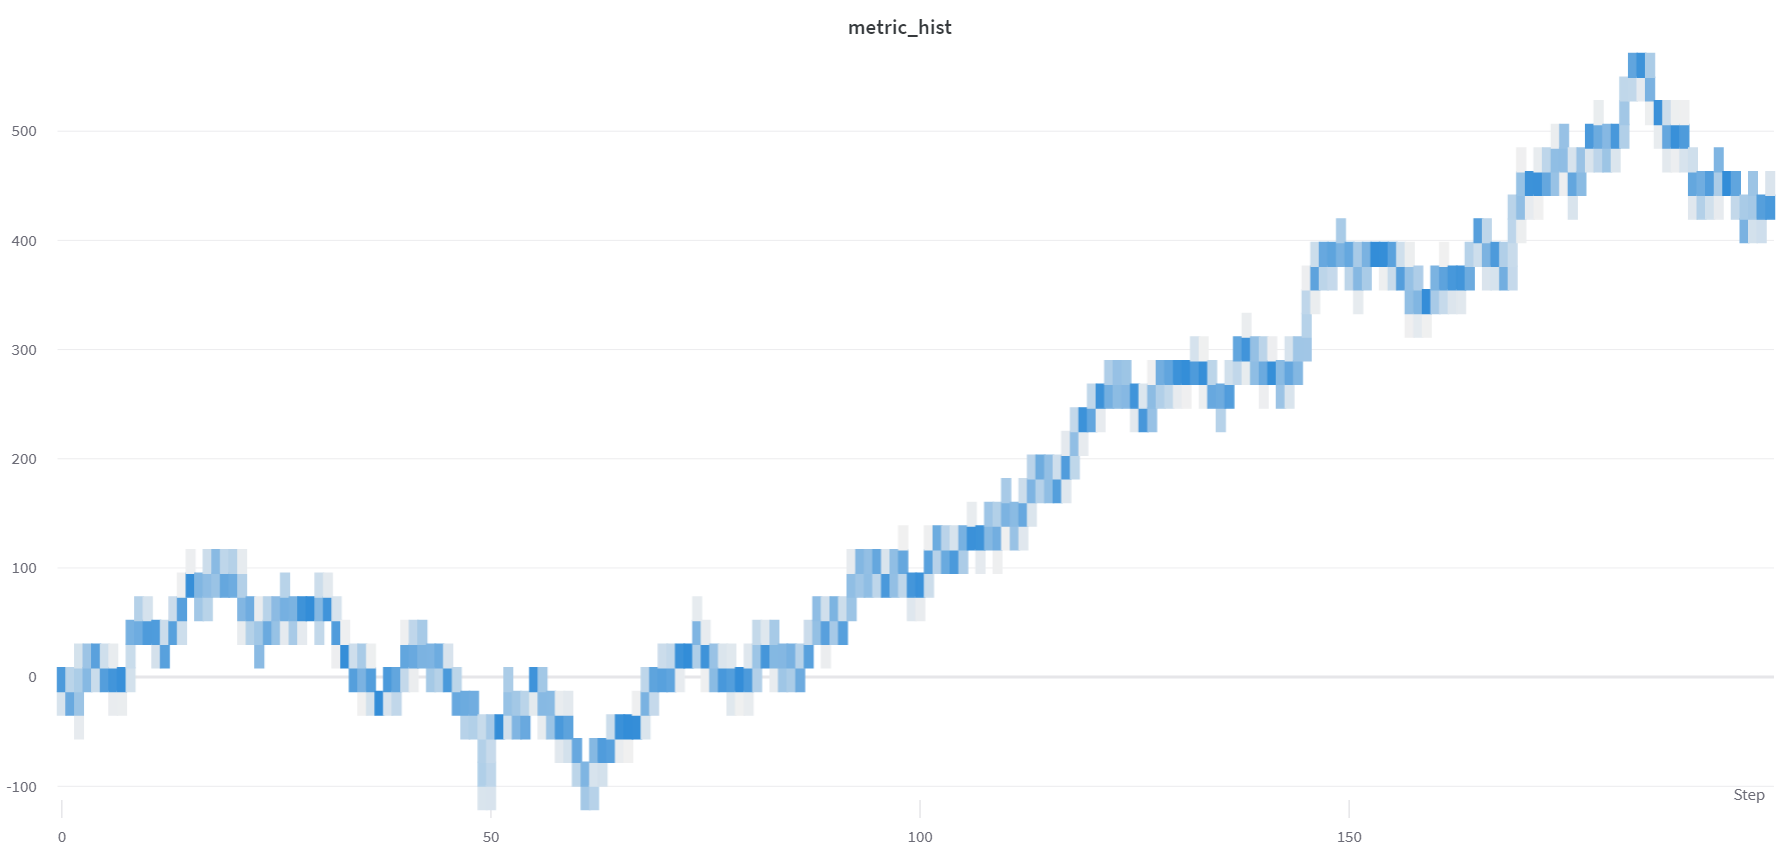

> _Note_:
the histogram chart will only show up on the
[run page](https://docs.wandb.ai/ref/app/pages/run-page),
which collects metrics from individual runs,
not on the
[project page](https://docs.wandb.ai/ref/app/pages/project-page),
which compares metrics across runs. 
A chart of histograms changing over time has enough going on already
before you start comparing histograms to each other!

Notice also that this run, logging histograms,
finishes in approximately the same amount of time
as do the runs which log scalars,
even though it seems like we're doing a lot more.
That's because here,
as in most contemporary computing settings,
the primary bottlenecks are in reading and writing files
and communicating across networks.

That's a good thing to keep in mind when
you're writing and profiling your ML code!

# 🐌 Log Everything

For purposes of comparison,
we also include the code to log the metric on every step,
without any summarization.

> <font color="red">Warning!</font> This cell takes a few minutes to run.
We put it at the end for a reason.

In [ ]:
%%time

total_steps = 100_000

run = wandb.init(project="perf-log",
                 name="log-everything") 
with run:
    random.seed(117)
    metric = 0
    for iter in range(total_steps):
        metric += random.randint(-1, 1)
        run.log({"metric": metric, "iter": iter})

    print("Run Finished!")

print("Logging Finished!")
print("\n" + timing_header)